### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rc('font',family='malgun gothic')
plt.rc('axes',unicode_minus=False)
import seaborn as sns

# EDA
import klib

# Preprocessing&Feature Engineering
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from gensim.models import word2vec

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

# Eveluation
from sklearn.metrics import mean_squared_error # squared=False시 RMSE
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import pickle

### Read Data

In [2]:
df_train =  pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
y_train =  pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949')
df_test =  pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
test_id = df_test['custid'].unique()

### Feature Generation&Feature Engineering

In [3]:
tr = pd.concat([df_train, df_test])
tr.head()

,custid,sales_month,sales_day,sales_dayofweek,sales_time,str_nm,goodcd,brd_nm,corner_nm,pc_nm,part_nm,team_nm,buyer_nm,import_flg,tot_amt,dis_amt,net_amt,inst_mon,inst_fee
0,0,6,25,일,1212,무역점,2116050008000,에스티로더,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,90000,9000,81000,3,0
1,0,6,25,일,1242,무역점,4125440008000,시슬리,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,39000,3900,35100,1,0
2,0,8,26,토,1810,본점,2116052008000,크리니크,수입종합화장품,화장품,잡화파트,잡화가용팀,화장품,1,175000,17500,157500,3,0
3,0,8,26,토,1830,본점,4106430119900,듀퐁,수입의류,명품토탈,잡화파트,잡화가용팀,수입명품,1,455000,45500,409500,3,0
4,0,9,3,일,1802,무역점,2139141008000,랑콤,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,0,100000,10000,90000,3,0


### PCA

In [4]:
# 차원축소 매소드 
from sklearn.decomposition import PCA

def dummy_to_pca(tr, column_name:str) :
    max_seq = 300
    max_d = 15
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['custid', column_name]]
    else:
        tops = col_count.index
        f =tr[['custid', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  # This method performs One-hot-encoding
    f = f.groupby('custid').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
    print(cumsum)
    num_d = np.argmax(cumsum >= 0.99) + 1 # 분산의 설명량이 99%이상 되는 차원의 수
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [5]:
features=pd.DataFrame({'custid':tr.custid.unique()})
f = dummy_to_pca(tr, 'brd_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'corner_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'pc_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'part_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'buyer_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'team_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'goodcd'); features = pd.merge(features,f,on='custid',how='left')

[0.20925819 0.26247578 0.31026524 0.35465584 0.39279151 0.42773016
 0.45686994 0.48238291 0.50635612 0.52855114 0.54644828 0.56310481
 0.57731784 0.58944097 0.60093382]
[0.27577009 0.32856671 0.36450786 0.39201513 0.41551164 0.43869649
 0.45870453 0.47724231 0.49342443 0.50875354 0.52284894 0.53625701
 0.54904885 0.5616339  0.57337447]
[0.30258006 0.35534362 0.3974377  0.43719501 0.46332711 0.48755566
 0.51030572 0.53138956 0.55126584 0.57053406 0.58885847 0.60525385
 0.62021204 0.63454674 0.64826916]
[0.1879969  0.36112839 0.48727324 0.5555609  0.61059754 0.65950855
 0.69744239 0.7270648  0.75559645 0.77902553 0.8018157  0.82369323
 0.84362078 0.86291734 0.88031064]
[0.32693065 0.48981179 0.56968538 0.62867222 0.67853989 0.71931297
 0.75523527 0.78396579 0.81148539 0.8370249  0.85987317 0.88190477
 0.90236185 0.92022774 0.9373244 ]
[0.63403846 0.99999985 1.         1.        ]
[0.23542319 0.29690401 0.34967812 0.39710801 0.44266303 0.48309861
 0.51751953 0.54674546 0.57378356 0.597742

### W2V-상품분류

In [ ]:
def age_vec():
    sentences = []
    df_all = df_train
    for id in tqdm(df_all.custid.unique()):
        x = df_all.query('custid == @id')[level].unique()
        y = y_train.query('custid == @id').age
        for j in range(20):
            y = np.append(y, np.random.choice(x, len(x), replace=False))
        sentences.append(list(y))

In [ ]:
level = 'corner_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

In [ ]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train2 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test2 = np.array(features_wv)

X_train2 = pd.DataFrame(X_train2)
X_test2 = pd.DataFrame(X_test2)
X_train2.insert(0,'custid',df_train.custid.unique())
X_test2.insert(0,'custid',df_test.custid.unique())

### W2V-브랜드명

In [12]:
### W2V-브랜드명level = 'brd_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

100%|████████████████████████████████████████████████████████████████████████████| 35967/35967 [10:06<00:00, 59.33it/s]


In [13]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [14]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train3 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test3 = np.array(features_wv)

100%|███████████████████████████████████████████████████████████████████████████| 14380/14380 [02:03<00:00, 116.12it/s]


In [15]:
X_train3 = pd.DataFrame(X_train3)
X_test3 = pd.DataFrame(X_test3)
X_train3.insert(0,'custid',df_train.custid.unique())
X_test3.insert(0,'custid',df_test.custid.unique())

In [8]:
def month_modify(x):
    if x > 12:
        return x-12
    else:
        return x

def extract_hour(x):
    if len(str(x))>3:
        return str(x)[:2]
    else: 
        return str(x)[:1]
def extract_season(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :    
        return('가을')
    else :
        return('겨울') 
def time_(x):
    if 9 <= x <= 11 :
        return('아침_구매건수')
    elif 12 <= x <= 17 :
        return('점심_구매건수')
    else :
        return('저녁_구매건수')
def half_year(x):
    if 1<=x<=5:
        return('전반기')
    else:
        return('후반기')
def peak_season(x):
    if x in [7,8,12,1,2]:
        return('성수기')
    else:
        return('비성수기')
def div_month(x):
    if 1<=x<=10:
        return('월초')
    elif 11<=x<=20:
        return('월중')
    else:
        return('월말')
def noon(x):
    if int(str(x)[-2:])<=12:
        return('오전')
    else:
        return('오후')

일반변수

In [10]:
df = tr.copy()
df['sales_hour'] = df.sales_time.apply(extract_hour)
df['sales_hour'] = pd.to_numeric(df['sales_hour'])
df['sales_hour'] = np.where(df['sales_hour'] < 9, 21, df['sales_hour'])
df['방문시간대'] = df.sales_hour.apply(time_)
df['sales_month'] = df.sales_month.apply(month_modify)
df['반기'] = df.sales_month.apply(half_year)
df['성수기여부'] = df.sales_month.apply(peak_season)
df['월_초중말'] = df.sales_day.apply(div_month)
df['오전/오후'] = df.sales_time.apply(noon)

# 총구매액
f = df.groupby('custid')['tot_amt'].agg([('총구매액', 'sum')]).reset_index()
features = pd.merge(features,f, on = 'custid')
# 평균구매액
f = df.groupby('custid')['tot_amt'].agg([('평균구매액', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 총할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.sum()).rename(columns={'dis_amt':'총할인금액'})
features = pd.merge(features,f, on = 'custid')
# 평균할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.mean()).rename(columns={'dis_amt':'평균할인금액'})
features = pd.merge(features,f, on = 'custid')

# 총실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.sum()).rename(columns={'net_amt':'총실구매액'})
features = pd.merge(features,f, on = 'custid')
# 평균실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.mean()).rename(columns={'net_amt':'평균실구매액'})
features = pd.merge(features,f, on = 'custid')

# 요일별 방문횟수
f = pd.crosstab(df.custid,df.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
features = pd.merge(features,f, on = 'custid')

# 시간별 방문횟수
f = pd.crosstab(df.custid, df.sales_hour).rename(columns=dict(zip(df.sales_hour.unique(),[str(i)+'시방문' for i in df.sales_hour.unique()])))
features = pd.merge(features,f, on = 'custid')

# 수입상품 구매 건수
f = pd.DataFrame(df.groupby('custid').import_flg.sum()).rename(columns={'import_flg':'수입상품구매건수'})
features = pd.merge(features,f, on = 'custid')

# x = df[df['import_flg'] == 1].groupby('custid').size()
# f = x.reset_index().rename(columns={0: '수입상품_구매건수'}).fillna(0)
# features = pd.merge(features,f, on = 'custid')

# 구매건수
f = df.groupby('custid')['tot_amt'].agg([('구매건수', 'size')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 평균할부개월수
f = df.groupby('custid')['inst_mon'].agg([('평균할부개월수', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 지점별 방문횟수
f = pd.crosstab(df.custid, df.str_nm).rename(columns=dict(zip(df.str_nm.unique(),[i+'방문' for i in df.str_nm.unique()])))
features = pd.merge(features,f, on = 'custid')

# 방문지점 수
f = df.groupby('custid')['str_nm'].agg([('방문지점수',lambda x: x.nunique())])
features = pd.merge(features,f, on = 'custid')

# 월별 구매횟수
f = pd.crosstab(df.custid,df.sales_month).rename(columns=dict(zip(df.sales_month.unique(), [str(i)+'월방문' for i in df.sales_month.unique()])))
features = pd.merge(features,f, on = 'custid')

# 구매일수
df['sales_month'] = df['sales_month'].astype(str)
df['sales_day'] = df['sales_day'].astype(str)
df['판매일'] = df['sales_month'] + '-' + df['sales_day']
df.판매일 = pd.to_datetime(df.판매일,format='%m-%d')
f = df.groupby(by = 'custid')['판매일'].agg([('구매일수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매주기
f = df.groupby('custid')['판매일'].agg([('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.nunique()))]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 최고 구입 금액
f = df.groupby('custid')['tot_amt'].agg([('최고구매금액', 'max')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 계절별 구매건수
df['sales_month'] = pd.to_numeric(df['sales_month'])
df['계절'] = df.sales_month.apply(extract_season)
f = pd.pivot_table(df, index = 'custid', columns = '계절', values = 'tot_amt',
                  aggfunc = np.size, fill_value = 0).reset_index()
features = pd.merge(features,f, on = 'custid')

# 반기별 구매건수
f = pd.crosstab(df.custid, df.반기).reset_index()
features = pd.merge(features,f, on = 'custid')

# 성수기 여부 별 구매건수
f = pd.crosstab(df.custid, df.성수기여부).reset_index()
features = pd.merge(features,f, on = 'custid')

# 월 시기별 구매건수
f = pd.crosstab(df.custid, df.월_초중말).reset_index()
features = pd.merge(features,f, on = 'custid')

# 오전/오후별 구매건수
f = pd.crosstab(df.custid, df['오전/오후']).reset_index()
features = pd.merge(features,f, on = 'custid')

# 방문지점 갯수
f = df.groupby(by = 'custid')['str_nm'].agg([('방문지점개수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매상품 다양성
n = df.corner_nm.nunique()
f = df.groupby('custid')['goodcd'].agg([('구매상품다양성', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 시간대별 방문횟수
f = pd.crosstab(df.custid, df.방문시간대)
features = pd.merge(features,f, on = 'custid')

# 주구매코너
#f = df.groupby('custid')['corner_nm'].agg([('주구매코너', lambda x: x.value_counts().index[0])]).reset_index()
#f = pd.get_dummies(f, columns=['주구매코너'])  # This method performs One-hot-encoding
#features = pd.merge(features,f, on = 'custid')

# 코너별 구매건수
f = pd.pivot_table(df, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 바이어 이름 별 구매건수
f = pd.pivot_table(df, index='custid', columns='buyer_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 무이자 할부 평균 가격
f = df.loc[df.inst_fee==1].groupby('custid').net_amt.agg([('무이자할부평균가격','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 할부결제건수
f = df.loc[df.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 내점 당 구매금액
f = df.groupby(['custid','판매일'])['tot_amt'].sum().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매금액','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 내점 당 구매개수
f = df.groupby(['custid','판매일'])['tot_amt'].count().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매개수','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 평균쇼핑시간
f = df.groupby(['custid','판매일'])['sales_time'].agg(lambda x: x.max()-x.min()).reset_index().groupby('custid').sales_time.agg([('평균쇼핑시간','mean')])
features = pd.merge(features,f,on='custid',how='left')

```python
# 파트별 구매액 합
f = pd.pivot_table(tr, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc='sum', fill_value=0).reset_index()
features = pd.merge(features,f, on = 'custid')

# 파트별 할인금액
f = pd.pivot_table(df, index='custid', columns='part_nm', values='dis_amt', 
                   aggfunc='sum', fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# part_nm별 구매건수
f = pd.pivot_table(df, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
```

In [10]:
del features['custid']

In [11]:
# 이상치 처리
features = features.apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)), axis=0)

# 표준화
features.loc[:,:] = RobustScaler().fit_transform(features)

비율변수

In [12]:
features['custid'] = tr.custid.unique()

tr['sales_hour'] = tr.sales_time.apply(extract_hour)
weekdays = pd.crosstab(tr.custid,tr.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
sales_hour = pd.crosstab(df.custid, df.sales_hour, margins=True)
sales_hour = sales_hour.rename(columns=dict(zip(sales_hour.columns,[str(i)+'시방문' for i in sales_hour.columns])))
str_nm = pd.crosstab(tr.custid, tr.str_nm,margins=True)
str_nm = str_nm.rename(columns=dict(zip(str_nm.columns,[i+'방문' for i in str_nm.columns])))
sales_month = pd.crosstab(df.custid,df.sales_month, margins=True)
sales_month = sales_month.rename(columns=dict(zip(sales_month.columns, [str(i)+'월방문' for i in sales_month])))
tr['sales_month'] = pd.to_numeric(tr['sales_month'])
tr['sales_month'] = tr.sales_month.apply(month_modify)
tr['season'] = pd.DataFrame(tr.sales_month.apply(extract_season))
season_visit = pd.crosstab(tr.custid, tr.season)
tr['mln'] = tr.sales_time.apply(lambda x: int(str(x)[:2])).apply(time_)
mln = pd.crosstab(tr.custid, tr.mln,margins=True)
inv = tr.loc[tr.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
trans_amount = tr.groupby('custid')['tot_amt'].agg([('구매건수', 'size')])
peak = pd.crosstab(df.custid, df.성수기여부, margins=True)
peak = peak.divide(peak.iloc[:,-1],axis=0).iloc[:-1,:-1]
half = pd.crosstab(df.custid, df.반기, margins=True)
half = half.divide(half.iloc[:,-1],axis=0).iloc[:-1,:-1]
noon = pd.crosstab(df.custid, df['오전/오후'], margins=True)
noon = noon.divide(noon.iloc[:,-1],axis=0).iloc[:-1,:-1]

In [13]:
# 수입상품 구매비율
x = df[df['import_flg'] == 1].groupby('custid').size() / df.groupby('custid').size()
f = x.reset_index().rename(columns={0: '수입상품구매비율'}).fillna(0)
f.iloc[:,1] = (f.iloc[:,1])
features = pd.merge(features,f, on = 'custid')

# 주말 방문 비율
day_to_int = {
    '월': 1,'화': 2,'수': 3,'목': 4,'금': 5,'토': 6,'일': 7}
df2 = df.copy()
df2['sales_dayofweek'] = df2['sales_dayofweek'].map(day_to_int)
df2 = pd.pivot_table(df, index='custid', columns='sales_dayofweek', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index();
df2['주말방문비율'] = ((df2.iloc[:,5]+df2.iloc[:,6]) / (df2.iloc[:,1]+df2.iloc[:,2]+df2.iloc[:,3]+df2.iloc[:,4]+
                                                df2.iloc[:,5]+df2.iloc[:,6]+df2.iloc[:,7]))
f = df2[['custid','주말방문비율']]
features = pd.merge(features,f, on = 'custid')

# 요일별 방문비율
f = weekdays.iloc[:,:-1].divide(weekdays.iloc[:,-1], axis=0).rename(columns=dict(zip(weekdays.columns,
                                                                                    [str(i)+'_prop' for i in weekdays.columns])))
features = pd.merge(features,f, on = 'custid')

# 시간별 방문비율
f = sales_hour.iloc[:-1,:-1].divide(sales_hour.iloc[:-1,-1],axis=0).rename(columns=dict(zip(sales_hour.columns,
                                                                                    [str(i)+'_prop' for i in sales_hour.columns])))
features = pd.merge(features,f, on = 'custid')
# 지점별 방문비율
f = str_nm.iloc[:-1,:-1].divide(str_nm.iloc[:-1,-1],axis=0).rename(columns=dict(zip(str_nm.columns,[str(i)+'_prop' for i in str_nm.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 구매월별 방문비율
f = sales_month.iloc[:-1,:-1].divide(sales_month.iloc[:-1,-1],axis=0).rename(columns=
                                                        dict(zip(sales_month.columns,[str(i)+'_prop' for i in sales_month.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 계절별 방문비율
f = season_visit.divide(weekdays.총방문횟수,axis=0).rename(columns=dict(zip(season_visit.columns,[column+'_prop' for column in season_visit.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 시간대별 방문비율
f = mln.div(mln.iloc[:,-1], axis=0).iloc[:-1,:-1].reset_index().rename(columns=dict(zip(mln.columns,[i+'_prop' for i in mln.columns])))
features = pd.merge(features,f, on = 'custid')
# 할부결제비율
f =(inv['할부결제건수']/trans_amount['구매건수']).reset_index().rename(columns={0:'할부결제비율'}).fillna(0)
features = pd.merge(features,f, on = 'custid')
# 성수기 방문비율
f = peak.iloc[:,1].reset_index().rename(columns={'성수기':'성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 비성수기 방문비율
f = peak.iloc[:,0].reset_index().rename(columns={'비성수기':'비성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 전반기 방문비율
f = half.iloc[:,0].reset_index().rename(columns={'전반기':'전반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 후반기 방문비율
f = half.iloc[:,1].reset_index().rename(columns={'후반기':'후반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오전 방문비율
f = noon.iloc[:,0].reset_index().rename(columns={'오전':'오전방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오후 방문비율
f = noon.iloc[:,1].reset_index().rename(columns={'오후':'오후방문비율'})
features = pd.merge(features,f, on = 'custid')
# 할인율 평균
df['할인율'] = df.dis_amt/df.tot_amt
f = df.groupby('custid')['할인율'].mean().reset_index()
features = pd.merge(features,f,on='custid',how='left')

In [14]:
features.shape

(35967, 55)

In [14]:
X_train = pd.DataFrame({'custid': df_train.custid.unique()})
X_train = pd.merge(X_train, features, how='left', on='custid')

X_test = pd.DataFrame({'custid': df_test.custid.unique()})
X_test = pd.merge(X_test, features, how='left', on='custid')

merge W2V

In [15]:
X_train = pd.merge(X_train, X_train2, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test2, how='left', on='custid')
X_test = X_test.set_index('custid')

In [16]:
X_train = pd.merge(X_train, X_train3, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test3, how='left', on='custid')
X_test = X_test.set_index('custid')

One-hot Encoding

In [28]:
level = 'corner_nm'
df_train[level].nunique()
IDtest = df_test.custid.unique()

df_all = pd.concat([df_train, df_test])
x_train = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid not in @IDtest'). \
                         set_index('custid')
x_test = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid in @IDtest'). \
                         set_index('custid')

x_train = pd.merge(x_train, X_train, on = 'custid')
x_test = pd.merge(x_test, X_test, on = 'custid')

### Feature Selection

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [04:09<00:00,  2.63s/it]

(49, -71.04728575632565)


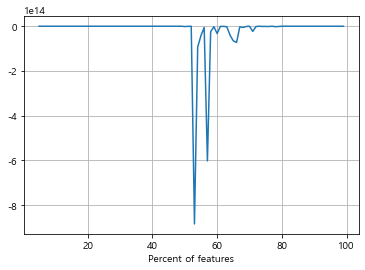

In [29]:
features = x_train
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LinearRegression()

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
# feature 개수 바꿔가며 성능 test한다.
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [30]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(x_train, y_train)
x_train = fs.transform(x_train)
x_test = fs.transform(x_test)

print(x_train.shape)
print(features.columns[fs.get_support()].tolist())

(21587, 389)
['건식품', '곡물', '골프(LC)', '골프(NB)', '골프(국내)', '골프(수입)', '골프단품', '골프웨어', '교복행사', '국내부띠끄', '냉장식품', '디자이너니트', '디자이너숍', '라이센스', '레포츠', '로얄부틱2F', '로얄수입행사', '문화', '부띠끄', '생선', '셔츠', '수예행사', '수입도자기', '수입부띠끄', '스포츠슈즈', '스포츠웨어', '신생아', '아동', '아동단품', '아동복', '아동잡화', '아동특선', '야채', '엘레강스', '엘레강스부틱', '영캐주얼', '완구', '완구(문화)', '욕실용품', '용기보증', '유아', '유아복', '임대골프', '잡화(문화)', '정육', '조미료', '주방용품', '진캐쥬얼', '청과', '침구', '타운웨어', '트래디셔널', 'brd_nm_0', 'brd_nm_9', 'brd_nm_10', 'brd_nm_11', 'corner_nm_0', 'corner_nm_1', 'corner_nm_2', 'corner_nm_3', 'corner_nm_4', 'corner_nm_5', 'corner_nm_7', 'corner_nm_10', 'corner_nm_12', 'corner_nm_13', 'corner_nm_14', 'pc_nm_0', 'pc_nm_1', 'pc_nm_2', 'pc_nm_3', 'pc_nm_4', 'pc_nm_7', 'pc_nm_8', 'pc_nm_9', 'pc_nm_10', 'part_nm_0', 'part_nm_2', 'part_nm_3', 'part_nm_5', 'part_nm_6', 'part_nm_8', 'part_nm_9', 'part_nm_12', 'part_nm_14', 'buyer_nm_0', 'buyer_nm_1', 'buyer_nm_2', 'buyer_nm_3', 'buyer_nm_4', 'buyer_nm_7', 'buyer_nm_13', 'team_nm_0', 'team_nm_1', 'goodcd_0

```python
pd.DataFrame(x_train,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train0606.csv')
pd.DataFrame(x_test,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train0606.csv')
```

### Model Tuning

In [32]:
x_train2, x_dev, y_train2, y_dev = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [33]:
clfs = [
    (
    LinearRegression(),
    {
        
    }),
        (
    Ridge(random_state=0),
    {
        'alpha':[1]
    }),
        (
    Lasso(random_state=0),
    {
        'alpha':[0.010101010101010102]
    }),
        (
    ElasticNet(random_state=0),
    {
        'alpha':[0.010101010101010102]
    }),
        (
    ARDRegression(),
    {
        'alpha_1':[0],
        'alpha_2':[1],
        'lambda_1':[1],
        'lambda_2':[0.6333]
    }),
        (
    BayesianRidge(),
    {
        'alpha_1':[0.7272727272727273],
        'alpha_2':[0.030303030303030304],
        'lambda_1':[0.9494949494949496],
        'lambda_2':[0.9494949494949496]
    }),
        (
    RandomForestRegressor(random_state=0),
    {
        'n_estimators':[400],
        'max_depth':[None]
    }),
        (
    XGBRegressor(random_state=0),
    {
        'n_estimators':[400],
        'learning_rate':[0.1],
        'max_depth':[3],
        'gamma':[0.7272727272727273],
        'reg_alpha':[0.9494949494949496],
        'reg_lambda':[0.9494949494949496]
    }),
        (
    LGBMRegressor(random_state=0),
    {
        'n_estimators':[200],
        'num_leaves':[90],
        'learning_rate':[0.1],
        'max_depth':[5],
        'reg_alpha':[0.56],
        'reg_lambda':[0.73]
        
    }),
        (
    CatBoostRegressor(random_state=0),
    {
        
    })
]
clfs_tuned = []
for clf, param_grid in tqdm(clfs):
    start = time.time()
    grid_search = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(x_train2, y_train2)
    clf_name = type(clf).__name__
    clf_score = np.sqrt(-grid_search.score(x_dev, y_dev))
    clfs_tuned.append([clf_name, grid_search, clf_score])
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))

 10%|████████▎                                                                          | 1/10 [00:06<00:55,  6.12s/it]

LinearRegression                                     8.432400 6.1


 20%|████████████████▌                                                                  | 2/10 [00:10<00:38,  4.82s/it]

Ridge                                                8.420540 3.9


 30%|████████████████████████▉                                                          | 3/10 [00:23<01:02,  8.91s/it]

Lasso                                                8.487759 13.8


 40%|█████████████████████████████████▏                                                 | 4/10 [00:38<01:06, 11.17s/it]

ElasticNet                                           8.493550 14.6


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:20<01:52, 22.48s/it]

ARDRegression                                        8.432008 42.5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:23<01:02, 15.69s/it]

BayesianRidge                                        8.443608 2.5


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [46:30<44:46, 895.61s/it]

RandomForestRegressor                                8.551214 2707.2


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [50:00<22:34, 677.34s/it]

XGBRegressor                                         8.401360 210.0


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [50:27<07:53, 473.89s/it]

LGBMRegressor                                        8.420317 26.5
Learning rate set to 0.063286
0:	learn: 10.2796317	total: 167ms	remaining: 2m 46s
1:	learn: 10.1389238	total: 213ms	remaining: 1m 46s
2:	learn: 10.0023814	total: 253ms	remaining: 1m 24s
3:	learn: 9.8884929	total: 294ms	remaining: 1m 13s
4:	learn: 9.7763435	total: 345ms	remaining: 1m 8s
5:	learn: 9.6713732	total: 386ms	remaining: 1m 3s
6:	learn: 9.5867433	total: 425ms	remaining: 1m
7:	learn: 9.5047967	total: 469ms	remaining: 58.2s
8:	learn: 9.4253759	total: 517ms	remaining: 56.9s
9:	learn: 9.3514602	total: 558ms	remaining: 55.2s
10:	learn: 9.2813580	total: 597ms	remaining: 53.7s
11:	learn: 9.2198138	total: 644ms	remaining: 53.1s
12:	learn: 9.1621526	total: 687ms	remaining: 52.1s
13:	learn: 9.1161530	total: 726ms	remaining: 51.1s
14:	learn: 9.0694322	total: 766ms	remaining: 50.3s
15:	learn: 9.0267256	total: 815ms	remaining: 50.1s
16:	learn: 8.9823430	total: 855ms	remaining: 49.4s
17:	learn: 8.9439624	total: 899ms	remainin

162:	learn: 7.8253800	total: 7.52s	remaining: 38.6s
163:	learn: 7.8208349	total: 7.57s	remaining: 38.6s
164:	learn: 7.8166578	total: 7.61s	remaining: 38.5s
165:	learn: 7.8127367	total: 7.65s	remaining: 38.4s
166:	learn: 7.8094204	total: 7.7s	remaining: 38.4s
167:	learn: 7.8043434	total: 7.74s	remaining: 38.3s
168:	learn: 7.7999331	total: 7.78s	remaining: 38.3s
169:	learn: 7.7950047	total: 7.82s	remaining: 38.2s
170:	learn: 7.7902444	total: 7.87s	remaining: 38.1s
171:	learn: 7.7864793	total: 7.91s	remaining: 38.1s
172:	learn: 7.7809921	total: 7.95s	remaining: 38s
173:	learn: 7.7767597	total: 8s	remaining: 38s
174:	learn: 7.7707638	total: 8.04s	remaining: 37.9s
175:	learn: 7.7667162	total: 8.08s	remaining: 37.8s
176:	learn: 7.7612527	total: 8.12s	remaining: 37.8s
177:	learn: 7.7582631	total: 8.16s	remaining: 37.7s
178:	learn: 7.7526525	total: 8.21s	remaining: 37.7s
179:	learn: 7.7477792	total: 8.25s	remaining: 37.6s
180:	learn: 7.7437413	total: 8.29s	remaining: 37.5s
181:	learn: 7.740337

325:	learn: 7.1370386	total: 14.8s	remaining: 30.5s
326:	learn: 7.1334548	total: 14.8s	remaining: 30.4s
327:	learn: 7.1289177	total: 14.8s	remaining: 30.4s
328:	learn: 7.1264665	total: 14.9s	remaining: 30.4s
329:	learn: 7.1225046	total: 14.9s	remaining: 30.3s
330:	learn: 7.1189851	total: 15s	remaining: 30.3s
331:	learn: 7.1162702	total: 15s	remaining: 30.2s
332:	learn: 7.1134796	total: 15.1s	remaining: 30.2s
333:	learn: 7.1107305	total: 15.1s	remaining: 30.1s
334:	learn: 7.1070606	total: 15.2s	remaining: 30.1s
335:	learn: 7.1035081	total: 15.2s	remaining: 30.1s
336:	learn: 7.0997250	total: 15.3s	remaining: 30s
337:	learn: 7.0964025	total: 15.3s	remaining: 30s
338:	learn: 7.0918500	total: 15.4s	remaining: 29.9s
339:	learn: 7.0882211	total: 15.4s	remaining: 29.9s
340:	learn: 7.0853441	total: 15.4s	remaining: 29.8s
341:	learn: 7.0823518	total: 15.5s	remaining: 29.8s
342:	learn: 7.0782738	total: 15.5s	remaining: 29.7s
343:	learn: 7.0749381	total: 15.6s	remaining: 29.7s
344:	learn: 7.071811

485:	learn: 6.6002668	total: 21.8s	remaining: 23.1s
486:	learn: 6.5983972	total: 21.9s	remaining: 23s
487:	learn: 6.5961479	total: 21.9s	remaining: 23s
488:	learn: 6.5943462	total: 22s	remaining: 22.9s
489:	learn: 6.5904549	total: 22s	remaining: 22.9s
490:	learn: 6.5880174	total: 22s	remaining: 22.9s
491:	learn: 6.5851988	total: 22.1s	remaining: 22.8s
492:	learn: 6.5816625	total: 22.1s	remaining: 22.8s
493:	learn: 6.5778971	total: 22.2s	remaining: 22.7s
494:	learn: 6.5746163	total: 22.2s	remaining: 22.7s
495:	learn: 6.5712568	total: 22.3s	remaining: 22.6s
496:	learn: 6.5692176	total: 22.3s	remaining: 22.6s
497:	learn: 6.5664412	total: 22.3s	remaining: 22.5s
498:	learn: 6.5643546	total: 22.4s	remaining: 22.5s
499:	learn: 6.5607294	total: 22.4s	remaining: 22.4s
500:	learn: 6.5575218	total: 22.5s	remaining: 22.4s
501:	learn: 6.5554514	total: 22.5s	remaining: 22.3s
502:	learn: 6.5521325	total: 22.6s	remaining: 22.3s
503:	learn: 6.5491534	total: 22.6s	remaining: 22.3s
504:	learn: 6.5458832	

646:	learn: 6.1294598	total: 29s	remaining: 15.8s
647:	learn: 6.1272979	total: 29.1s	remaining: 15.8s
648:	learn: 6.1247277	total: 29.1s	remaining: 15.7s
649:	learn: 6.1224669	total: 29.2s	remaining: 15.7s
650:	learn: 6.1191723	total: 29.2s	remaining: 15.7s
651:	learn: 6.1172083	total: 29.3s	remaining: 15.6s
652:	learn: 6.1138744	total: 29.3s	remaining: 15.6s
653:	learn: 6.1111479	total: 29.3s	remaining: 15.5s
654:	learn: 6.1084223	total: 29.4s	remaining: 15.5s
655:	learn: 6.1040910	total: 29.4s	remaining: 15.4s
656:	learn: 6.1012282	total: 29.5s	remaining: 15.4s
657:	learn: 6.0983184	total: 29.5s	remaining: 15.4s
658:	learn: 6.0956802	total: 29.6s	remaining: 15.3s
659:	learn: 6.0920626	total: 29.6s	remaining: 15.3s
660:	learn: 6.0893954	total: 29.7s	remaining: 15.2s
661:	learn: 6.0860537	total: 29.7s	remaining: 15.2s
662:	learn: 6.0843883	total: 29.8s	remaining: 15.1s
663:	learn: 6.0820372	total: 29.8s	remaining: 15.1s
664:	learn: 6.0790628	total: 29.9s	remaining: 15s
665:	learn: 6.07

806:	learn: 5.7008032	total: 36.4s	remaining: 8.72s
807:	learn: 5.6983860	total: 36.5s	remaining: 8.67s
808:	learn: 5.6950352	total: 36.5s	remaining: 8.63s
809:	learn: 5.6925509	total: 36.6s	remaining: 8.58s
810:	learn: 5.6898275	total: 36.6s	remaining: 8.53s
811:	learn: 5.6869733	total: 36.7s	remaining: 8.49s
812:	learn: 5.6837850	total: 36.7s	remaining: 8.44s
813:	learn: 5.6808069	total: 36.8s	remaining: 8.4s
814:	learn: 5.6786870	total: 36.8s	remaining: 8.35s
815:	learn: 5.6768953	total: 36.8s	remaining: 8.31s
816:	learn: 5.6740852	total: 36.9s	remaining: 8.26s
817:	learn: 5.6711850	total: 36.9s	remaining: 8.22s
818:	learn: 5.6685238	total: 37s	remaining: 8.17s
819:	learn: 5.6657028	total: 37s	remaining: 8.13s
820:	learn: 5.6634535	total: 37.1s	remaining: 8.08s
821:	learn: 5.6610927	total: 37.1s	remaining: 8.04s
822:	learn: 5.6591707	total: 37.2s	remaining: 7.99s
823:	learn: 5.6576368	total: 37.2s	remaining: 7.95s
824:	learn: 5.6556743	total: 37.2s	remaining: 7.9s
825:	learn: 5.6534

968:	learn: 5.3244594	total: 43.7s	remaining: 1.4s
969:	learn: 5.3220042	total: 43.7s	remaining: 1.35s
970:	learn: 5.3210693	total: 43.8s	remaining: 1.31s
971:	learn: 5.3185489	total: 43.8s	remaining: 1.26s
972:	learn: 5.3160639	total: 43.8s	remaining: 1.22s
973:	learn: 5.3139592	total: 43.9s	remaining: 1.17s
974:	learn: 5.3114872	total: 43.9s	remaining: 1.13s
975:	learn: 5.3093481	total: 44s	remaining: 1.08s
976:	learn: 5.3064119	total: 44s	remaining: 1.04s
977:	learn: 5.3047775	total: 44.1s	remaining: 992ms
978:	learn: 5.3030557	total: 44.1s	remaining: 946ms
979:	learn: 5.3010912	total: 44.2s	remaining: 901ms
980:	learn: 5.2984351	total: 44.2s	remaining: 856ms
981:	learn: 5.2965557	total: 44.3s	remaining: 811ms
982:	learn: 5.2950214	total: 44.3s	remaining: 766ms
983:	learn: 5.2923568	total: 44.3s	remaining: 721ms
984:	learn: 5.2900407	total: 44.4s	remaining: 676ms
985:	learn: 5.2872053	total: 44.4s	remaining: 631ms
986:	learn: 5.2853290	total: 44.5s	remaining: 586ms
987:	learn: 5.283

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [54:22<00:00, 326.24s/it]

CatBoostRegressor                                    8.316877 235.2


### Model Ensemble

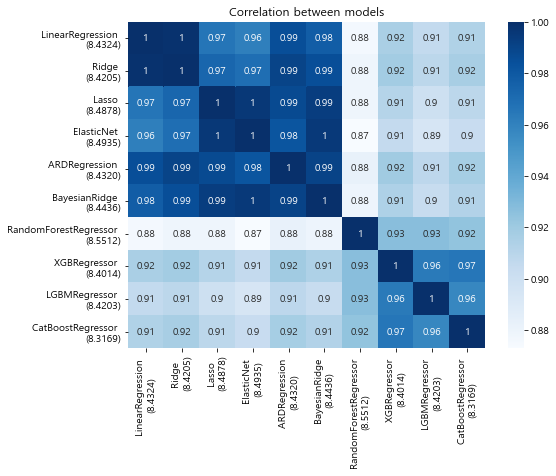

In [34]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = list(clf.predict(x_dev))
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

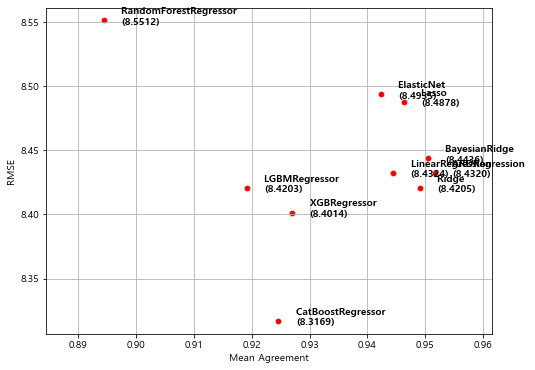

In [35]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [40]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train2,y_train2)
score = mean_squared_error(avg_reg.predict(x_dev), y_dev, squared=False)
score

Learning rate set to 0.063286
0:	learn: 10.2796317	total: 39.1ms	remaining: 39.1s
1:	learn: 10.1389238	total: 94.2ms	remaining: 47s
2:	learn: 10.0023814	total: 142ms	remaining: 47.3s
3:	learn: 9.8884929	total: 197ms	remaining: 49s
4:	learn: 9.7763435	total: 259ms	remaining: 51.5s
5:	learn: 9.6713732	total: 337ms	remaining: 55.7s
6:	learn: 9.5867433	total: 383ms	remaining: 54.3s
7:	learn: 9.5047967	total: 431ms	remaining: 53.5s
8:	learn: 9.4253759	total: 482ms	remaining: 53.1s
9:	learn: 9.3514602	total: 534ms	remaining: 52.9s
10:	learn: 9.2813580	total: 587ms	remaining: 52.8s
11:	learn: 9.2198138	total: 635ms	remaining: 52.3s
12:	learn: 9.1621526	total: 689ms	remaining: 52.3s
13:	learn: 9.1161530	total: 750ms	remaining: 52.8s
14:	learn: 9.0694322	total: 811ms	remaining: 53.2s
15:	learn: 9.0267256	total: 872ms	remaining: 53.6s
16:	learn: 8.9823430	total: 930ms	remaining: 53.8s
17:	learn: 8.9439624	total: 996ms	remaining: 54.3s
18:	learn: 8.9093687	total: 1.07s	remaining: 55.1s
19:	learn:

161:	learn: 7.8304708	total: 8.35s	remaining: 43.2s
162:	learn: 7.8253800	total: 8.39s	remaining: 43.1s
163:	learn: 7.8208349	total: 8.45s	remaining: 43.1s
164:	learn: 7.8166578	total: 8.5s	remaining: 43s
165:	learn: 7.8127367	total: 8.54s	remaining: 42.9s
166:	learn: 7.8094204	total: 8.59s	remaining: 42.9s
167:	learn: 7.8043434	total: 8.64s	remaining: 42.8s
168:	learn: 7.7999331	total: 8.68s	remaining: 42.7s
169:	learn: 7.7950047	total: 8.72s	remaining: 42.6s
170:	learn: 7.7902444	total: 8.77s	remaining: 42.5s
171:	learn: 7.7864793	total: 8.81s	remaining: 42.4s
172:	learn: 7.7809921	total: 8.86s	remaining: 42.4s
173:	learn: 7.7767597	total: 8.9s	remaining: 42.3s
174:	learn: 7.7707638	total: 8.95s	remaining: 42.2s
175:	learn: 7.7667162	total: 9s	remaining: 42.1s
176:	learn: 7.7612527	total: 9.04s	remaining: 42.1s
177:	learn: 7.7582631	total: 9.1s	remaining: 42s
178:	learn: 7.7526525	total: 9.14s	remaining: 41.9s
179:	learn: 7.7477792	total: 9.19s	remaining: 41.9s
180:	learn: 7.7437413	

324:	learn: 7.1401668	total: 16s	remaining: 33.2s
325:	learn: 7.1370386	total: 16s	remaining: 33.1s
326:	learn: 7.1334548	total: 16.1s	remaining: 33.1s
327:	learn: 7.1289177	total: 16.1s	remaining: 33s
328:	learn: 7.1264665	total: 16.2s	remaining: 33s
329:	learn: 7.1225046	total: 16.2s	remaining: 32.9s
330:	learn: 7.1189851	total: 16.3s	remaining: 32.9s
331:	learn: 7.1162702	total: 16.3s	remaining: 32.8s
332:	learn: 7.1134796	total: 16.3s	remaining: 32.7s
333:	learn: 7.1107305	total: 16.4s	remaining: 32.7s
334:	learn: 7.1070606	total: 16.4s	remaining: 32.6s
335:	learn: 7.1035081	total: 16.5s	remaining: 32.6s
336:	learn: 7.0997250	total: 16.5s	remaining: 32.5s
337:	learn: 7.0964025	total: 16.6s	remaining: 32.5s
338:	learn: 7.0918500	total: 16.6s	remaining: 32.4s
339:	learn: 7.0882211	total: 16.7s	remaining: 32.4s
340:	learn: 7.0853441	total: 16.7s	remaining: 32.3s
341:	learn: 7.0823518	total: 16.8s	remaining: 32.3s
342:	learn: 7.0782738	total: 16.8s	remaining: 32.2s
343:	learn: 7.074938

484:	learn: 6.6032541	total: 23.5s	remaining: 25s
485:	learn: 6.6002668	total: 23.6s	remaining: 24.9s
486:	learn: 6.5983972	total: 23.6s	remaining: 24.9s
487:	learn: 6.5961479	total: 23.7s	remaining: 24.8s
488:	learn: 6.5943462	total: 23.7s	remaining: 24.8s
489:	learn: 6.5904549	total: 23.8s	remaining: 24.7s
490:	learn: 6.5880174	total: 23.8s	remaining: 24.7s
491:	learn: 6.5851988	total: 23.9s	remaining: 24.6s
492:	learn: 6.5816625	total: 23.9s	remaining: 24.6s
493:	learn: 6.5778971	total: 24s	remaining: 24.6s
494:	learn: 6.5746163	total: 24s	remaining: 24.5s
495:	learn: 6.5712568	total: 24.1s	remaining: 24.5s
496:	learn: 6.5692176	total: 24.2s	remaining: 24.5s
497:	learn: 6.5664412	total: 24.2s	remaining: 24.4s
498:	learn: 6.5643546	total: 24.3s	remaining: 24.4s
499:	learn: 6.5607294	total: 24.3s	remaining: 24.3s
500:	learn: 6.5575218	total: 24.4s	remaining: 24.3s
501:	learn: 6.5554514	total: 24.4s	remaining: 24.2s
502:	learn: 6.5521325	total: 24.5s	remaining: 24.2s
503:	learn: 6.5491

645:	learn: 6.1323743	total: 31.7s	remaining: 17.3s
646:	learn: 6.1294598	total: 31.7s	remaining: 17.3s
647:	learn: 6.1272979	total: 31.8s	remaining: 17.3s
648:	learn: 6.1247277	total: 31.8s	remaining: 17.2s
649:	learn: 6.1224669	total: 31.9s	remaining: 17.2s
650:	learn: 6.1191723	total: 31.9s	remaining: 17.1s
651:	learn: 6.1172083	total: 32s	remaining: 17.1s
652:	learn: 6.1138744	total: 32s	remaining: 17s
653:	learn: 6.1111479	total: 32.1s	remaining: 17s
654:	learn: 6.1084223	total: 32.2s	remaining: 16.9s
655:	learn: 6.1040910	total: 32.2s	remaining: 16.9s
656:	learn: 6.1012282	total: 32.3s	remaining: 16.8s
657:	learn: 6.0983184	total: 32.3s	remaining: 16.8s
658:	learn: 6.0956802	total: 32.4s	remaining: 16.7s
659:	learn: 6.0920626	total: 32.4s	remaining: 16.7s
660:	learn: 6.0893954	total: 32.5s	remaining: 16.6s
661:	learn: 6.0860537	total: 32.5s	remaining: 16.6s
662:	learn: 6.0843883	total: 32.6s	remaining: 16.6s
663:	learn: 6.0820372	total: 32.6s	remaining: 16.5s
664:	learn: 6.079062

807:	learn: 5.6983860	total: 39.7s	remaining: 9.43s
808:	learn: 5.6950352	total: 39.8s	remaining: 9.39s
809:	learn: 5.6925509	total: 39.8s	remaining: 9.34s
810:	learn: 5.6898275	total: 39.9s	remaining: 9.29s
811:	learn: 5.6869733	total: 39.9s	remaining: 9.24s
812:	learn: 5.6837850	total: 40s	remaining: 9.19s
813:	learn: 5.6808069	total: 40s	remaining: 9.15s
814:	learn: 5.6786870	total: 40.1s	remaining: 9.1s
815:	learn: 5.6768953	total: 40.2s	remaining: 9.05s
816:	learn: 5.6740852	total: 40.2s	remaining: 9.01s
817:	learn: 5.6711850	total: 40.3s	remaining: 8.96s
818:	learn: 5.6685238	total: 40.3s	remaining: 8.91s
819:	learn: 5.6657028	total: 40.4s	remaining: 8.86s
820:	learn: 5.6634535	total: 40.4s	remaining: 8.81s
821:	learn: 5.6610927	total: 40.5s	remaining: 8.76s
822:	learn: 5.6591707	total: 40.5s	remaining: 8.71s
823:	learn: 5.6576368	total: 40.5s	remaining: 8.66s
824:	learn: 5.6556743	total: 40.6s	remaining: 8.61s
825:	learn: 5.6534964	total: 40.6s	remaining: 8.56s
826:	learn: 5.651

969:	learn: 5.3220042	total: 48.1s	remaining: 1.49s
970:	learn: 5.3210693	total: 48.1s	remaining: 1.44s
971:	learn: 5.3185489	total: 48.2s	remaining: 1.39s
972:	learn: 5.3160639	total: 48.2s	remaining: 1.34s
973:	learn: 5.3139592	total: 48.3s	remaining: 1.29s
974:	learn: 5.3114872	total: 48.3s	remaining: 1.24s
975:	learn: 5.3093481	total: 48.4s	remaining: 1.19s
976:	learn: 5.3064119	total: 48.4s	remaining: 1.14s
977:	learn: 5.3047775	total: 48.5s	remaining: 1.09s
978:	learn: 5.3030557	total: 48.5s	remaining: 1.04s
979:	learn: 5.3010912	total: 48.6s	remaining: 991ms
980:	learn: 5.2984351	total: 48.6s	remaining: 942ms
981:	learn: 5.2965557	total: 48.7s	remaining: 892ms
982:	learn: 5.2950214	total: 48.7s	remaining: 843ms
983:	learn: 5.2923568	total: 48.8s	remaining: 793ms
984:	learn: 5.2900407	total: 48.9s	remaining: 744ms
985:	learn: 5.2872053	total: 48.9s	remaining: 694ms
986:	learn: 5.2853290	total: 49s	remaining: 645ms
987:	learn: 5.2831227	total: 49s	remaining: 595ms
988:	learn: 5.28

8.263992514202883

### Deployment

In [41]:
# ensemble-
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train,y_train)
pd.DataFrame({'custid': test_id, 'age': avg_reg.predict(x_test)}).to_csv('averaging_rid_cat.csv', index=False)

Learning rate set to 0.067435
0:	learn: 10.2630725	total: 39.2ms	remaining: 39.1s
1:	learn: 10.1146097	total: 84.2ms	remaining: 42s
2:	learn: 9.9750191	total: 128ms	remaining: 42.4s
3:	learn: 9.8606041	total: 170ms	remaining: 42.2s
4:	learn: 9.7441188	total: 213ms	remaining: 42.4s
5:	learn: 9.6396062	total: 263ms	remaining: 43.6s
6:	learn: 9.5418629	total: 310ms	remaining: 44s
7:	learn: 9.4646895	total: 360ms	remaining: 44.6s
8:	learn: 9.3859281	total: 409ms	remaining: 45s
9:	learn: 9.3190056	total: 460ms	remaining: 45.5s
10:	learn: 9.2557883	total: 509ms	remaining: 45.7s
11:	learn: 9.1926205	total: 560ms	remaining: 46.1s
12:	learn: 9.1369927	total: 613ms	remaining: 46.6s
13:	learn: 9.0882931	total: 664ms	remaining: 46.8s
14:	learn: 9.0440149	total: 719ms	remaining: 47.2s
15:	learn: 9.0039554	total: 769ms	remaining: 47.3s
16:	learn: 8.9644737	total: 822ms	remaining: 47.6s
17:	learn: 8.9293019	total: 890ms	remaining: 48.6s
18:	learn: 8.8949555	total: 942ms	remaining: 48.7s
19:	learn: 8.

163:	learn: 7.9340349	total: 8.43s	remaining: 43s
164:	learn: 7.9301961	total: 8.48s	remaining: 42.9s
165:	learn: 7.9255364	total: 8.54s	remaining: 42.9s
166:	learn: 7.9225342	total: 8.59s	remaining: 42.9s
167:	learn: 7.9183461	total: 8.64s	remaining: 42.8s
168:	learn: 7.9150894	total: 8.69s	remaining: 42.7s
169:	learn: 7.9108010	total: 8.75s	remaining: 42.7s
170:	learn: 7.9060973	total: 8.8s	remaining: 42.6s
171:	learn: 7.9014044	total: 8.84s	remaining: 42.6s
172:	learn: 7.8978427	total: 8.9s	remaining: 42.6s
173:	learn: 7.8947679	total: 8.95s	remaining: 42.5s
174:	learn: 7.8915698	total: 9s	remaining: 42.4s
175:	learn: 7.8874913	total: 9.04s	remaining: 42.3s
176:	learn: 7.8828749	total: 9.09s	remaining: 42.3s
177:	learn: 7.8795811	total: 9.13s	remaining: 42.2s
178:	learn: 7.8754432	total: 9.18s	remaining: 42.1s
179:	learn: 7.8726356	total: 9.22s	remaining: 42s
180:	learn: 7.8690799	total: 9.27s	remaining: 42s
181:	learn: 7.8652924	total: 9.32s	remaining: 41.9s
182:	learn: 7.8626018	t

323:	learn: 7.3837645	total: 16.2s	remaining: 33.9s
324:	learn: 7.3812443	total: 16.3s	remaining: 33.8s
325:	learn: 7.3772733	total: 16.3s	remaining: 33.8s
326:	learn: 7.3751421	total: 16.4s	remaining: 33.7s
327:	learn: 7.3727520	total: 16.4s	remaining: 33.7s
328:	learn: 7.3708646	total: 16.5s	remaining: 33.6s
329:	learn: 7.3684309	total: 16.5s	remaining: 33.6s
330:	learn: 7.3661920	total: 16.6s	remaining: 33.5s
331:	learn: 7.3618991	total: 16.6s	remaining: 33.4s
332:	learn: 7.3588516	total: 16.7s	remaining: 33.4s
333:	learn: 7.3561517	total: 16.7s	remaining: 33.3s
334:	learn: 7.3534441	total: 16.8s	remaining: 33.3s
335:	learn: 7.3499017	total: 16.8s	remaining: 33.2s
336:	learn: 7.3476384	total: 16.9s	remaining: 33.2s
337:	learn: 7.3451119	total: 16.9s	remaining: 33.1s
338:	learn: 7.3421543	total: 17s	remaining: 33.1s
339:	learn: 7.3391949	total: 17s	remaining: 33s
340:	learn: 7.3363956	total: 17.1s	remaining: 33s
341:	learn: 7.3341384	total: 17.1s	remaining: 32.9s
342:	learn: 7.330954

486:	learn: 6.9357170	total: 24s	remaining: 25.2s
487:	learn: 6.9332844	total: 24s	remaining: 25.2s
488:	learn: 6.9306885	total: 24.1s	remaining: 25.2s
489:	learn: 6.9276303	total: 24.1s	remaining: 25.1s
490:	learn: 6.9264531	total: 24.2s	remaining: 25s
491:	learn: 6.9240625	total: 24.2s	remaining: 25s
492:	learn: 6.9215288	total: 24.3s	remaining: 24.9s
493:	learn: 6.9182658	total: 24.3s	remaining: 24.9s
494:	learn: 6.9156806	total: 24.4s	remaining: 24.8s
495:	learn: 6.9135817	total: 24.4s	remaining: 24.8s
496:	learn: 6.9107059	total: 24.4s	remaining: 24.7s
497:	learn: 6.9078094	total: 24.5s	remaining: 24.7s
498:	learn: 6.9058723	total: 24.5s	remaining: 24.6s
499:	learn: 6.9040000	total: 24.6s	remaining: 24.6s
500:	learn: 6.9008822	total: 24.6s	remaining: 24.5s
501:	learn: 6.8992578	total: 24.7s	remaining: 24.5s
502:	learn: 6.8967324	total: 24.7s	remaining: 24.4s
503:	learn: 6.8933253	total: 24.8s	remaining: 24.4s
504:	learn: 6.8910709	total: 24.8s	remaining: 24.3s
505:	learn: 6.889386

645:	learn: 6.5368454	total: 31.5s	remaining: 17.3s
646:	learn: 6.5343785	total: 31.6s	remaining: 17.2s
647:	learn: 6.5318885	total: 31.6s	remaining: 17.2s
648:	learn: 6.5292907	total: 31.6s	remaining: 17.1s
649:	learn: 6.5272183	total: 31.7s	remaining: 17.1s
650:	learn: 6.5241722	total: 31.8s	remaining: 17s
651:	learn: 6.5218051	total: 31.8s	remaining: 17s
652:	learn: 6.5196794	total: 31.8s	remaining: 16.9s
653:	learn: 6.5168544	total: 31.9s	remaining: 16.9s
654:	learn: 6.5139586	total: 32s	remaining: 16.8s
655:	learn: 6.5122091	total: 32s	remaining: 16.8s
656:	learn: 6.5094413	total: 32.1s	remaining: 16.7s
657:	learn: 6.5064558	total: 32.1s	remaining: 16.7s
658:	learn: 6.5045494	total: 32.2s	remaining: 16.6s
659:	learn: 6.5023653	total: 32.2s	remaining: 16.6s
660:	learn: 6.4994390	total: 32.3s	remaining: 16.5s
661:	learn: 6.4967750	total: 32.3s	remaining: 16.5s
662:	learn: 6.4940291	total: 32.4s	remaining: 16.5s
663:	learn: 6.4923227	total: 32.4s	remaining: 16.4s
664:	learn: 6.489691

807:	learn: 6.1670606	total: 39.2s	remaining: 9.31s
808:	learn: 6.1647293	total: 39.2s	remaining: 9.26s
809:	learn: 6.1627337	total: 39.3s	remaining: 9.21s
810:	learn: 6.1604011	total: 39.3s	remaining: 9.17s
811:	learn: 6.1590112	total: 39.4s	remaining: 9.12s
812:	learn: 6.1561595	total: 39.4s	remaining: 9.07s
813:	learn: 6.1545089	total: 39.5s	remaining: 9.02s
814:	learn: 6.1527483	total: 39.5s	remaining: 8.97s
815:	learn: 6.1516327	total: 39.6s	remaining: 8.92s
816:	learn: 6.1492330	total: 39.6s	remaining: 8.87s
817:	learn: 6.1469655	total: 39.7s	remaining: 8.82s
818:	learn: 6.1450237	total: 39.7s	remaining: 8.78s
819:	learn: 6.1430376	total: 39.8s	remaining: 8.72s
820:	learn: 6.1416789	total: 39.8s	remaining: 8.68s
821:	learn: 6.1394062	total: 39.8s	remaining: 8.63s
822:	learn: 6.1371861	total: 39.9s	remaining: 8.58s
823:	learn: 6.1352182	total: 39.9s	remaining: 8.53s
824:	learn: 6.1330760	total: 40s	remaining: 8.48s
825:	learn: 6.1314194	total: 40s	remaining: 8.44s
826:	learn: 6.12

969:	learn: 5.8434710	total: 46.8s	remaining: 1.45s
970:	learn: 5.8412885	total: 46.8s	remaining: 1.4s
971:	learn: 5.8391238	total: 46.8s	remaining: 1.35s
972:	learn: 5.8377190	total: 46.9s	remaining: 1.3s
973:	learn: 5.8363618	total: 46.9s	remaining: 1.25s
974:	learn: 5.8349150	total: 47s	remaining: 1.2s
975:	learn: 5.8333804	total: 47s	remaining: 1.16s
976:	learn: 5.8316621	total: 47.1s	remaining: 1.11s
977:	learn: 5.8301203	total: 47.1s	remaining: 1.06s
978:	learn: 5.8288885	total: 47.2s	remaining: 1.01s
979:	learn: 5.8271949	total: 47.2s	remaining: 963ms
980:	learn: 5.8252974	total: 47.2s	remaining: 915ms
981:	learn: 5.8230709	total: 47.3s	remaining: 867ms
982:	learn: 5.8212976	total: 47.3s	remaining: 819ms
983:	learn: 5.8191777	total: 47.4s	remaining: 770ms
984:	learn: 5.8174727	total: 47.4s	remaining: 722ms
985:	learn: 5.8158117	total: 47.5s	remaining: 674ms
986:	learn: 5.8136085	total: 47.5s	remaining: 626ms
987:	learn: 5.8110600	total: 47.6s	remaining: 578ms
988:	learn: 5.80903

In [42]:
with open('averaging_rid_cat','wb') as f:
    pickle.dump(avg_reg, f)